In [2]:
import re
import os
import time
import glob
import joblib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from scipy.stats import norm
from scipy.ndimage import gaussian_filter
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.core.lattice import Lattice
from pymatgen.core.structure import Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator
import xrayutilities as xru
from xrayutilities.materials.cif import CIFFile
from xrayutilities.materials.material import Crystal
import warnings
warnings.filterwarnings("ignore")


def load_plt_setting():
    plt.style.use('seaborn-white')
    mpl.rcParams['font.sans-serif'] = "Arial"
    mpl.rcParams['font.family'] = "sans-serif"
    mpl.rcParams['axes.linewidth'] = 2
    font = {'size': 32}
    mpl.rc('font', **font)
    mpl.rcParams['xtick.major.pad']='8'
    mpl.rcParams['ytick.major.pad']='8'
    plt.rcParams["font.weight"] = "normal"
    plt.rcParams["axes.labelweight"] = "normal"
    plt.rcParams['svg.fonttype'] = 'none'
    mpl.rcParams['axes.linewidth'] = 2
    
def scherrer_fwhm(crystal_size, theta, wavelength=1.5406, shape_factor=0.9):
    theta_rad = np.deg2rad(theta/2)
    fwhm = (shape_factor*wavelength)/(crystal_size*np.cos(theta_rad))
    return fwhm

def get_simulated_pattern(index, xrd_dataset):
    return xrd_dataset['xrd_patterns'][index], xrd_dataset['texts'][index], xrd_dataset['labels'][index]

def generate_two_mixed_xrd(idx1,idx2):   ###idx comes from xrd_dataset.xlsx
    new_texts = []
    new_labels = []
    phase1, text1, label1 = get_simulated_pattern(idx1)
    noisy_phase1 = generate_noisy_xrd(phase1, crystal_size_range, position_shift_std_range, intensity_variation_std_range, peak_loss_probability_range)
    new_texts.append(text1)
    new_labels.append(label1)
    phase2, text2, label2 = get_simulated_pattern(idx2)
    noisy_phase2 = generate_noisy_xrd(phase2, crystal_size_range, position_shift_std_range, intensity_variation_std_range, peak_loss_probability_range)
    new_texts.append(text2)
    new_labels.append(label2)
    ratio1 = np.random.uniform(0,1)
    ratio2 = 1. - ratio1
    two_mixed_xrd = ratio1 * noisy_phase1 + ratio2 * noisy_phase2
    two_mixed_xrd = two_mixed_xrd / np.max(two_mixed_xrd) * 100.  # Normalize to 100
    return two_mixed_xrd, new_texts, new_labels

# New cif for mix A/B/X perovskite

In [3]:
folder = r'K:\Python\MIT\ML\XRD_Phase_identification'
cif_folder = os.path.join(folder, 'cif')

mix_dic = {}
with open(os.path.join(cif_folder, 'cif_for_mix_ABX.txt')) as file:
    cif_for_mix = [line.rstrip() for line in file]

for data in cif_for_mix:
    cif_name, A, B, X = data.split('\t')
    print(cif_name, A, B, X)
    for x, y in [(A,B),(A,X),(B,X)]:
        mix_element = list(set([A,B,X]) - set([x,y]))[0]
        mix_pos = [A,B,X].index(mix_element)
        try:
            sample_list = mix_dic['{}-{}'.format(x,y)]['sample_list']
            element_list = mix_dic['{}-{}'.format(x,y)]['element_list']
            sample_list.append(cif_name)
            element_list.append(mix_element)
            mix_dic['{}-{}'.format(x,y)]['sample_list'] = sample_list
            mix_dic['{}-{}'.format(x,y)]['element_list'] = element_list
        except:
            mix_dic['{}-{}'.format(x,y)] = {'sample_list':[cif_name], 
                                            'element_list':[mix_element],
                                            'mix_pos':mix_pos}

print(mix_dic)

161481 Cs Pb I
201251 Cs Pb Cl
231017 Cs Pb Br
235794 MA Pb Br
235795 FA Pb Br
250735 MA Pb I
250736 FA Pb I
{'Cs-Pb': {'sample_list': ['161481', '201251', '231017'], 'element_list': ['I', 'Cl', 'Br'], 'mix_pos': 2}, 'Cs-I': {'sample_list': ['161481'], 'element_list': ['Pb'], 'mix_pos': 1}, 'Pb-I': {'sample_list': ['161481', '250735', '250736'], 'element_list': ['Cs', 'MA', 'FA'], 'mix_pos': 0}, 'Cs-Cl': {'sample_list': ['201251'], 'element_list': ['Pb'], 'mix_pos': 1}, 'Pb-Cl': {'sample_list': ['201251'], 'element_list': ['Cs'], 'mix_pos': 0}, 'Cs-Br': {'sample_list': ['231017'], 'element_list': ['Pb'], 'mix_pos': 1}, 'Pb-Br': {'sample_list': ['231017', '235794', '235795'], 'element_list': ['Cs', 'MA', 'FA'], 'mix_pos': 0}, 'MA-Pb': {'sample_list': ['235794', '250735'], 'element_list': ['Br', 'I'], 'mix_pos': 2}, 'MA-Br': {'sample_list': ['235794'], 'element_list': ['Pb'], 'mix_pos': 1}, 'FA-Pb': {'sample_list': ['235795', '250736'], 'element_list': ['Br', 'I'], 'mix_pos': 2}, 'FA-Br'

In [4]:
for shared_element, data in mix_dic.items():
    sample_list = data['sample_list']
    element_list = data['element_list']
    mix_pos = data['mix_pos']
    shared_element_list = shared_element.split('-')
    
    if len(sample_list) > 1:
        sample_pair_list = [(sample1, sample2) for i, sample1 in enumerate(sample_list) for sample2 in sample_list[i + 1:]]
        
        for (sample1, sample2) in sample_pair_list:
            structure1 = Structure.from_file(os.path.join(cif_folder, sample1+'.cif'))
            abc1 = np.array(structure1.lattice.abc)
            structure2 = Structure.from_file(os.path.join(cif_folder, sample2+'.cif'))
            abc2 = np.array(structure2.lattice.abc)
            strain3D_list = np.linspace([0,0,0],abc2/abc1-1,6)[1:-1]
            
            for i, strain in enumerate(strain3D_list):
                formula = shared_element_list.copy()
                formula.insert(mix_pos, element_list[sample_list.index(sample2)]+'0.{}'.format(i*2+2))
                formula.insert(mix_pos, element_list[sample_list.index(sample1)]+'0.{}'.format(8-i*2))
                formula = ''.join(formula)
                print(formula)
                structure1.apply_strain(strain)
                structure1.to(os.path.join(cif_folder, 'mix', '{}.cif'.format(formula)))
                structure1.apply_strain(1/(1+strain)-1)

CsPbI0.8Cl0.2
CsPbI0.6Cl0.4
CsPbI0.4Cl0.6
CsPbI0.2Cl0.8
CsPbI0.8Br0.2
CsPbI0.6Br0.4
CsPbI0.4Br0.6
CsPbI0.2Br0.8
CsPbCl0.8Br0.2
CsPbCl0.6Br0.4
CsPbCl0.4Br0.6
CsPbCl0.2Br0.8
Cs0.8MA0.2PbI
Cs0.6MA0.4PbI
Cs0.4MA0.6PbI
Cs0.2MA0.8PbI
Cs0.8FA0.2PbI
Cs0.6FA0.4PbI
Cs0.4FA0.6PbI
Cs0.2FA0.8PbI
MA0.8FA0.2PbI
MA0.6FA0.4PbI
MA0.4FA0.6PbI
MA0.2FA0.8PbI
Cs0.8MA0.2PbBr
Cs0.6MA0.4PbBr
Cs0.4MA0.6PbBr
Cs0.2MA0.8PbBr
Cs0.8FA0.2PbBr
Cs0.6FA0.4PbBr
Cs0.4FA0.6PbBr
Cs0.2FA0.8PbBr
MA0.8FA0.2PbBr
MA0.6FA0.4PbBr
MA0.4FA0.6PbBr
MA0.2FA0.8PbBr
MAPbBr0.8I0.2
MAPbBr0.6I0.4
MAPbBr0.4I0.6
MAPbBr0.2I0.8
FAPbBr0.8I0.2
FAPbBr0.6I0.4
FAPbBr0.4I0.6
FAPbBr0.2I0.8


# Preprocess

In [5]:
# folder = r'/Users/shengfang/Dropbox (MIT)/XRD phase identification/'
folder = r'K:\Python\MIT\ML\XRD_Phase_identification'
cif_folder = os.path.join(folder, 'cif')

xrd_calculator = XRDCalculator(wavelength="CuKa1")
# xrd_x = np.arange(5.00, 60.01, 0.01)
strain1D_list = list(np.linspace(-0.02,0.02,9))
strain3D_list = np.array(np.meshgrid(strain1D_list,strain1D_list,strain1D_list)).T.reshape(-1,3)
possible_element = ['Cs','FA','MA','Pb','Sn','I','Br','Cl']

dataset = {}

# Load mix cif
for cif_file in os.listdir(os.path.join(cif_folder, 'mix')):
    if cif_file.endswith('.cif'):
        structure = Structure.from_file(os.path.join(cif_folder, 'mix', cif_file))
        space_group = SpacegroupAnalyzer(structure).get_crystal_system()
        formula = cif_file[:-4]
        element_list = []
        halide_list = []
        for element in possible_element:
            if element in formula:
                element_list.append(element)
                if element in ['I','Br','Cl']:
                    halide_list.append(element)
        if len(halide_list) > 1:
            first_halide_index = min(formula.index(halide_list[0]),formula.index(halide_list[-1]))
            formula = formula[:first_halide_index] + '(' + formula[first_halide_index:] + ')3'
        else:
            formula = formula + '3'
            
        print('Processing {}'.format(formula))
        xrd_list = []
        time_start = time.time()
        for strain in strain3D_list:
            structure.apply_strain(strain)
            xrd_pattern = xrd_calculator.get_pattern(structure)
            mask = (xrd_pattern.x >= 5) & (xrd_pattern.x <= 60)
            xrd_list.append((xrd_pattern.x[mask], xrd_pattern.y[mask]))
            structure.apply_strain(1/(1+strain)-1)
        print('Finished in {} s.'.format(time.time() - time_start))
        
        dataset[cif_file[:-4]] = {'formula':formula, 'element_list':element_list, 'space_group':space_group, 'xrd_list':xrd_list}
        print(formula,space_group,element_list)

Processing Cs0.2FA0.8PbBr3
Finished in 22.679115295410156 s.
Cs0.2FA0.8PbBr3 cubic ['Cs', 'FA', 'Pb', 'Br']
Processing Cs0.2FA0.8PbI3
Finished in 84.85088849067688 s.
Cs0.2FA0.8PbI3 tetragonal ['Cs', 'FA', 'Pb', 'I']
Processing Cs0.2MA0.8PbBr3
Finished in 22.41937565803528 s.
Cs0.2MA0.8PbBr3 cubic ['Cs', 'MA', 'Pb', 'Br']
Processing Cs0.2MA0.8PbI3
Finished in 26.232264757156372 s.
Cs0.2MA0.8PbI3 cubic ['Cs', 'MA', 'Pb', 'I']
Processing Cs0.4FA0.6PbBr3
Finished in 22.52109456062317 s.
Cs0.4FA0.6PbBr3 cubic ['Cs', 'FA', 'Pb', 'Br']
Processing Cs0.4FA0.6PbI3
Finished in 67.00513935089111 s.
Cs0.4FA0.6PbI3 tetragonal ['Cs', 'FA', 'Pb', 'I']
Processing Cs0.4MA0.6PbBr3
Finished in 22.09058952331543 s.
Cs0.4MA0.6PbBr3 cubic ['Cs', 'MA', 'Pb', 'Br']
Processing Cs0.4MA0.6PbI3
Finished in 26.12000298500061 s.
Cs0.4MA0.6PbI3 cubic ['Cs', 'MA', 'Pb', 'I']
Processing Cs0.6FA0.4PbBr3
Finished in 22.150766611099243 s.
Cs0.6FA0.4PbBr3 cubic ['Cs', 'FA', 'Pb', 'Br']
Processing Cs0.6FA0.4PbI3
Finished i

In [6]:
ICSD_label_list = []
with open(os.path.join(cif_folder, 'label.txt')) as file:
    for line in file:
        ICSD_label_list.append(line.rstrip().split('\t'))
ICSD_label_list = np.array(ICSD_label_list)
print(ICSD_label_list)

[['21955' 'CsPbI3' 'gamma-CsPbI3']
 ['32306' 'CsPbI3' 'delta-CsPbI3']
 ['42013' 'PbI2' 'PbI2']
 ['44540' 'Cs4PbBr6' 'Cs4PbBr6']
 ['48997' 'CsPb2Br5' 'CsPb2Br5']
 ['56522' 'CsI' 'CsI']
 ['84525' 'CsPbBr3' 'orthorhombic-CsPbBr3']
 ['161481' 'CsPbI3' 'alpha-CsPbI3']
 ['230491' 'FAPbI3' 'delta-FAPbI3']
 ['230492' 'FAPbI3' 'beta-FAPbI3']
 ['235794' 'MAPbBr3' 'cubic-MAPbBr3']
 ['235795' 'FAPbBr3' 'cubic-FAPbBr3']
 ['236387' 'CsBr' 'CsBr']
 ['238610' 'MAPbI3' 'tetragonal-MAPbI3']
 ['239760' 'PbBr2' 'PbBr2']
 ['250736' 'FAPbI3' 'alpha-FAPbI3']
 ['250741' 'FAPbI3' 'delta-FAPbI3']
 ['33037' 'MAPbBr3' 'tetragonal-MAPbBr3']
 ['231017' 'CsPbBr3' 'cubic-CsPbBr3']
 ['250735' 'MAPbI3' 'alpha-MAPbI3']
 ['201251' 'CsPbCl3' 'cubic-CsPbCl3']
 ['230496' 'CsPbCl3' 'Pbnm-CsPbCl3']
 ['241415' 'MAPbCl3' 'Pnma-MAPbCl3']
 ['243734' 'CsPbCl3' 'Pnma-CsPbCl3']]


In [7]:
# Load ICSD cif
for i, cif_file in enumerate(ICSD_label_list[:,0]):
    
    structure = Structure.from_file(os.path.join(cif_folder, cif_file+'.cif'))
    space_group = SpacegroupAnalyzer(structure).get_crystal_system()
    element_list = []
    for element in possible_element:
        if element in ICSD_label_list[i,1]:
            element_list.append(element)
    formula = ICSD_label_list[i,2]
    print(cif_file, element_list, formula)

    print('Processing {}'.format(formula))
    xrd_list = []
    time_start = time.time()
    for strain in strain3D_list:
        structure.apply_strain(strain)
        xrd_pattern = xrd_calculator.get_pattern(structure)
        mask = (xrd_pattern.x >= 5) & (xrd_pattern.x <= 60)
        xrd_list.append((xrd_pattern.x[mask], xrd_pattern.y[mask]))
        structure.apply_strain(1/(1+strain)-1)
    print('Finished in {} s.'.format(time.time() - time_start))

    dataset[cif_file] = {'formula':formula, 'element_list':element_list, 'space_group':space_group, 'xrd_list':xrd_list}
        
with open(os.path.join(cif_folder, 'dataset.npy'), 'wb') as handle:
    joblib.dump(dataset, handle)

21955 ['Cs', 'Pb', 'I'] gamma-CsPbI3
Processing gamma-CsPbI3
Finished in 119.04711413383484 s.
32306 ['Cs', 'Pb', 'I'] delta-CsPbI3
Processing delta-CsPbI3
Finished in 122.2525086402893 s.
42013 ['Pb', 'I'] PbI2
Processing PbI2
Finished in 13.27554988861084 s.
44540 ['Cs', 'Pb', 'Br'] Cs4PbBr6
Processing Cs4PbBr6
Finished in 587.3808267116547 s.
48997 ['Cs', 'Pb', 'Br'] CsPb2Br5
Processing CsPb2Br5
Finished in 146.3776969909668 s.
56522 ['Cs', 'I'] CsI
Processing CsI
Finished in 10.272259712219238 s.
84525 ['Cs', 'Pb', 'Br'] orthorhombic-CsPbBr3
Processing orthorhombic-CsPbBr3
Finished in 97.7093334197998 s.
161481 ['Cs', 'Pb', 'I'] alpha-CsPbI3
Processing alpha-CsPbI3
Finished in 25.514538049697876 s.
230491 ['FA', 'Pb', 'I'] delta-FAPbI3
Processing delta-FAPbI3
Finished in 83.40975189208984 s.
230492 ['FA', 'Pb', 'I'] beta-FAPbI3
Processing beta-FAPbI3
Finished in 57.6086950302124 s.
235794 ['MA', 'Pb', 'Br'] cubic-MAPbBr3
Processing cubic-MAPbBr3
Finished in 24.631027936935425 s.
23

In [8]:
dataset['FAPbBr0.8I0.2']

{'formula': 'FAPb(Br0.8I0.2)3',
 'element_list': ['FA', 'Pb', 'I', 'Br'],
 'space_group': 'tetragonal',
 'xrd_list': [(array([12.90381401, 13.70026091, 18.86299395, 19.42182162, 23.38733172,
          25.97498855, 27.60141145, 29.47932075, 30.57787887, 30.93620747,
          32.63943189, 33.64498064, 38.26290313, 39.40149798, 39.43151475,
          40.82362786, 41.65756539, 41.90399151, 41.93252033, 44.05450071,
          44.29012783, 44.31741526, 46.35193956, 47.82713631, 48.78326909,
          49.99026951, 50.91613906, 50.94068858, 52.08688985, 52.78044963,
          53.42023599, 55.42466554, 56.96841291, 56.99114366, 57.38186699,
          58.05466843, 58.70027608, 58.89223619, 58.91449393]),
   array([5.68263059e+01, 1.00000000e+02, 3.76784172e+01, 1.76144130e+01,
          3.07725254e+00, 3.96299902e+01, 6.79027868e+01, 4.03241646e+01,
          3.67805841e+01, 3.57122866e+01, 1.11338936e+01, 2.05776453e+01,
          4.85889701e+01, 3.62035132e+00, 2.23257561e+01, 3.56723073e+01,

In [9]:
dataset['161481']

{'formula': 'alpha-CsPbI3',
 'element_list': ['Cs', 'Pb', 'I'],
 'space_group': 'cubic',
 'xrd_list': [(array([14.3582979 , 20.3595535 , 25.00217651, 28.94843836, 32.45431946,
          35.65088365, 41.39998125, 44.03830749, 46.5564869 , 48.97387997,
          51.30555935, 53.56354844, 55.75763668, 59.98527366]),
   array([ 39.98618748,  39.61029331,  35.85332664, 100.        ,
           23.53028318,  20.04255261,  75.74420597,  12.9899845 ,
            9.6048452 ,  15.93283988,  26.99740055,   5.88946579,
           11.41584359,  12.6674976 ])),
  (array([14.28503224, 14.3582979 , 20.3073974 , 20.3595535 , 24.95926195,
          28.79830945, 28.94843836, 32.31897684, 32.42053101, 32.45431946,
          35.52631595, 35.61977717, 41.29024112, 41.39998125, 43.80316346,
          43.93392271, 44.01222975, 44.03830749, 46.33141383, 46.53152021,
          46.5564869 , 48.75731411, 48.94985234, 51.21261696, 53.3605389 ,
          53.47338776, 53.56354844, 55.56009295, 55.6698969 , 55.735710

# ----- Playground (not in use) ----- 

In [9]:
folder = r'K:\Python\MIT\ML\XRD_Phase_identification'
cif_folder = os.path.join(folder, 'cif')

with open(os.path.join(cif_folder, 'dataset.npy'), 'rb') as handle:
    dataset = joblib.load(handle)

time_start = time.time()

# Parameters for error generation
twotheta = np.arange(5.00, 60.01, 0.01)
crystal_size_range = (5, 20)

intensity_variation_range = (0.2, 1)  # percentage
peak_probability_range = (0.2, 1)  # probability of peak
num_patterns = 1000  # number of noisy patterns to generate per CIF file

# Iterate through simulated XRD patterns
xrd_patterns_list = []
texts_list = []
labels_list = []

for i in range(0, len(xrd_dataset['xrd_patterns'])):
    data_y, texts, labels = get_simulated_pattern(i, xrd_dataset)
    for j in range(0, num_patterns):
        data_ys = generate_noisy_xrd(data_y, xrd_x, intensity_variation_range, peak_probability_range)
        xrd_patterns_list.append(data_ys/np.max(data_ys))
        texts_list.append(texts)
        labels_list.append(labels)

noisy_xrd_dataset = {
    "xrd_patterns": xrd_patterns_list,
    "texts": texts_list,
    "labels": labels_list
}

with open(noisy_xrd_dataset_path, 'wb') as handle:
    joblib.dump(noisy_xrd_dataset, handle)

print('Finished in {} s.'.format(time.time() - time_start))

Finished in 6.196119070053101 s.


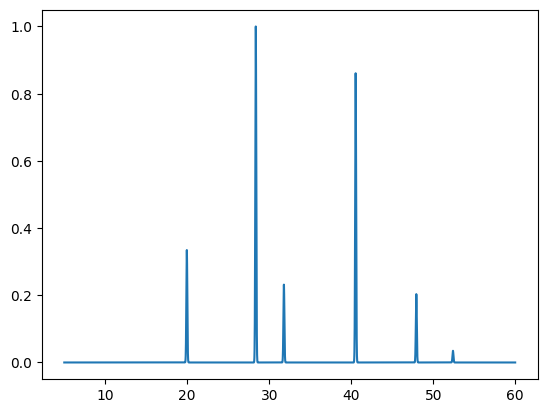

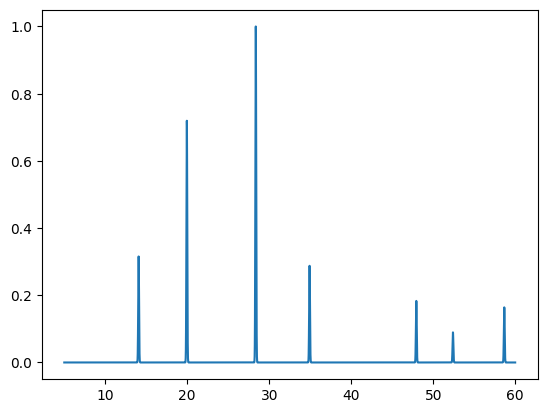

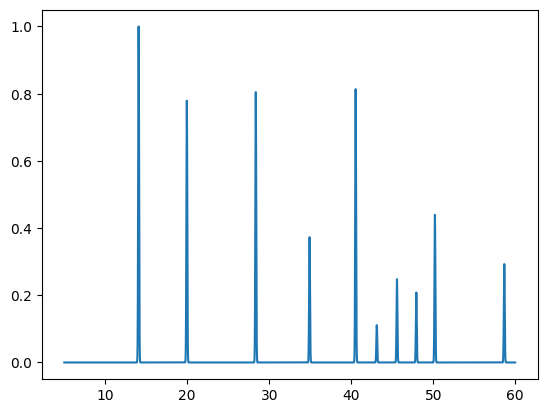

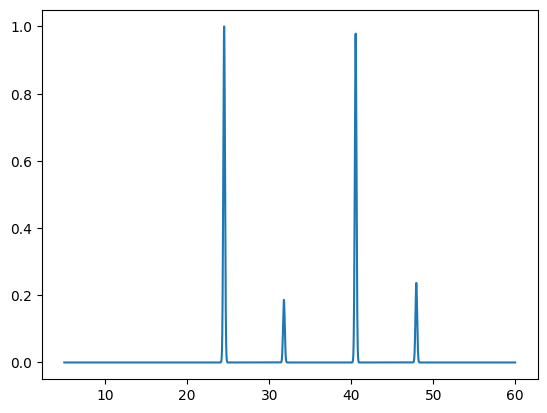

In [32]:
plt.figure(0)
plt.plot(xrd_x, xrd_patterns_list[0])
plt.figure(1)
plt.plot(xrd_x, xrd_patterns_list[1])
plt.figure(2)
plt.plot(xrd_x, xrd_patterns_list[2])
plt.figure(3)
plt.plot(xrd_x, xrd_patterns_list[3])

(5501,)


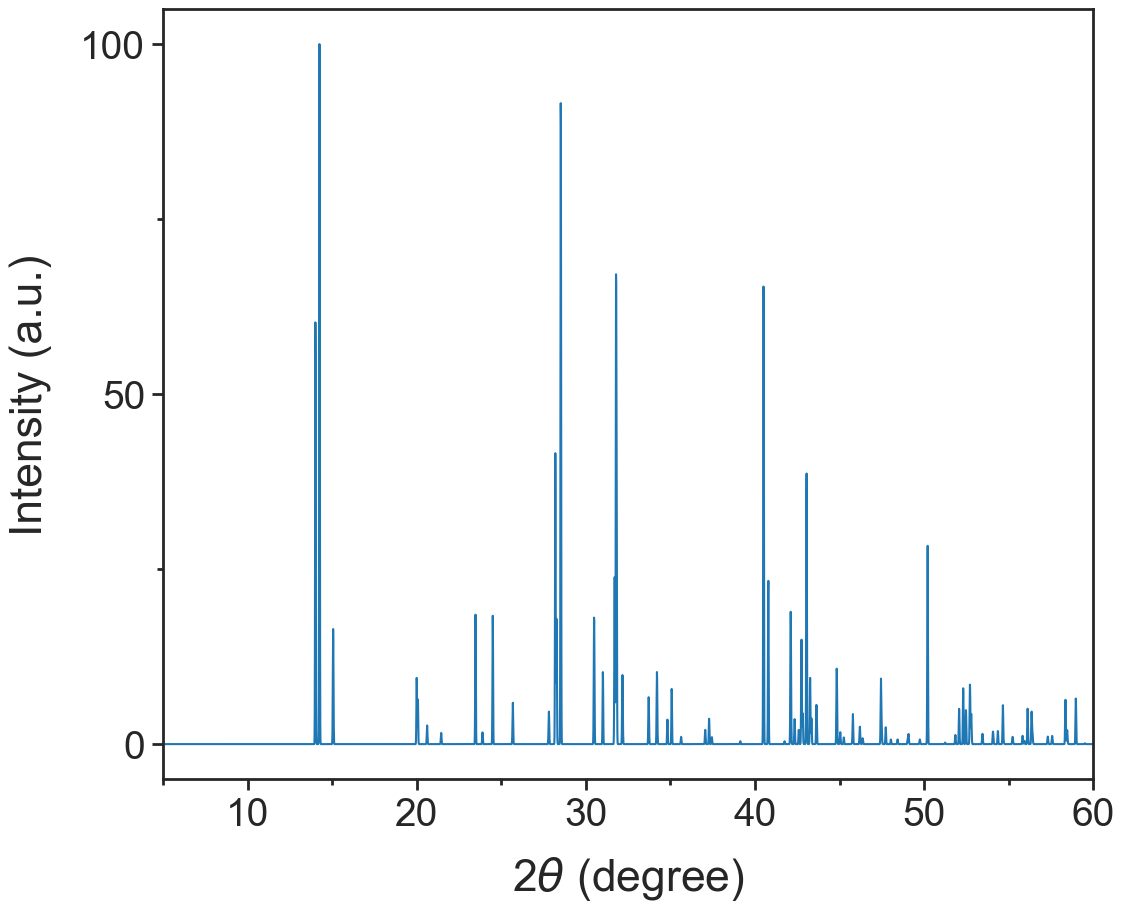

(5501,)


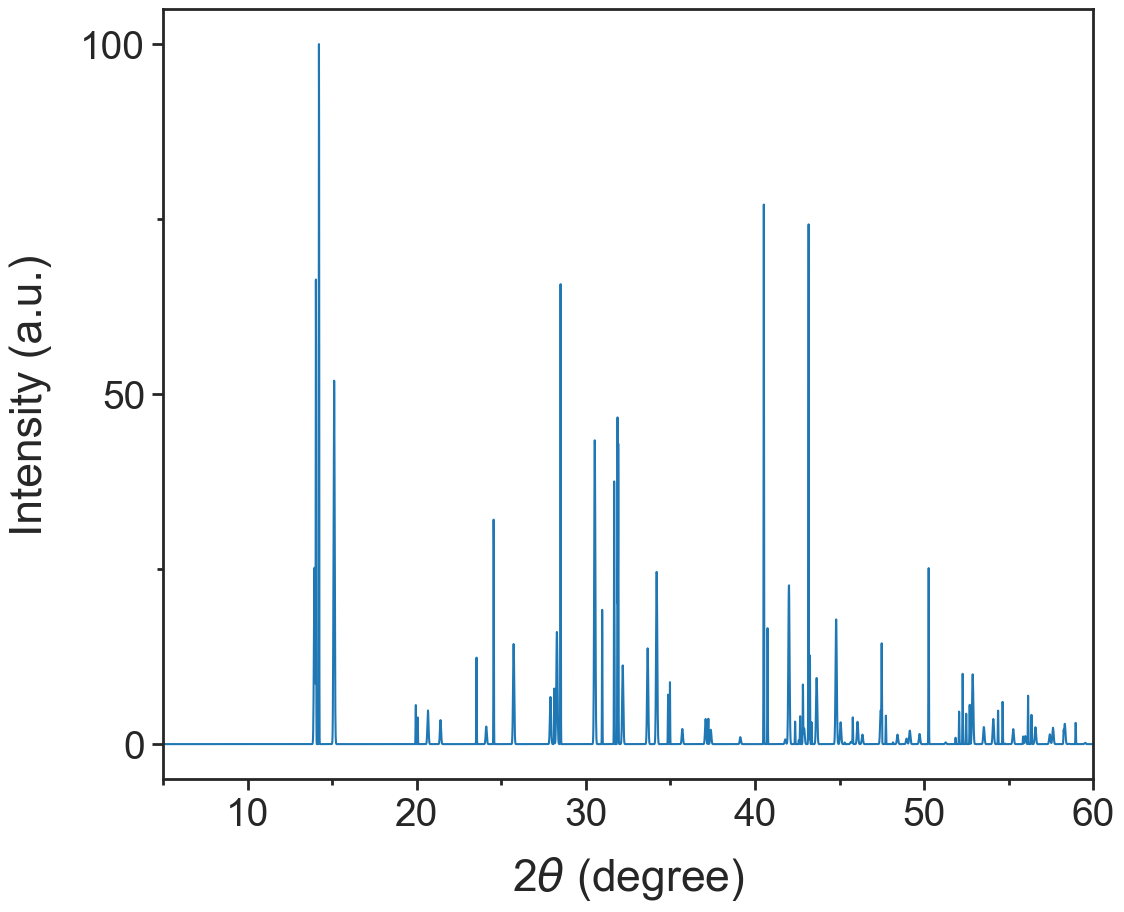

(5501,)


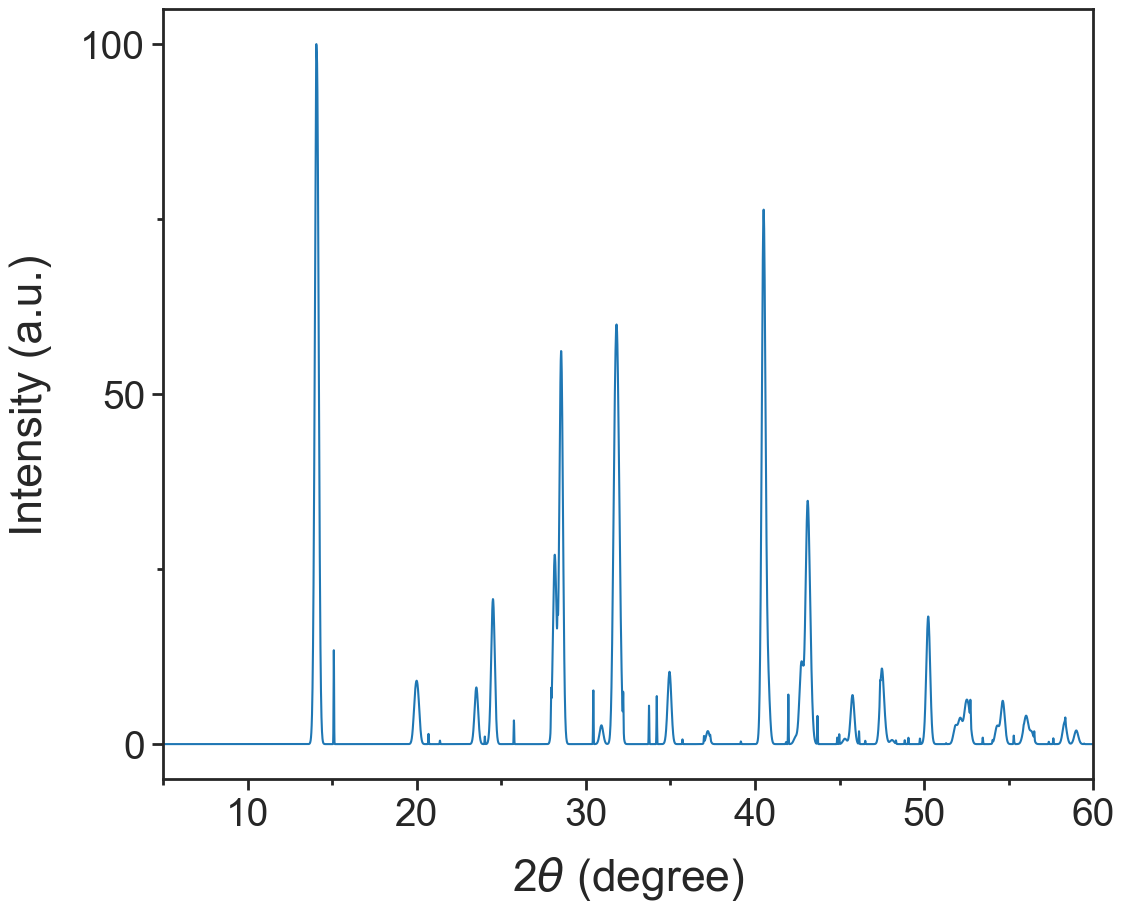

(5501,)


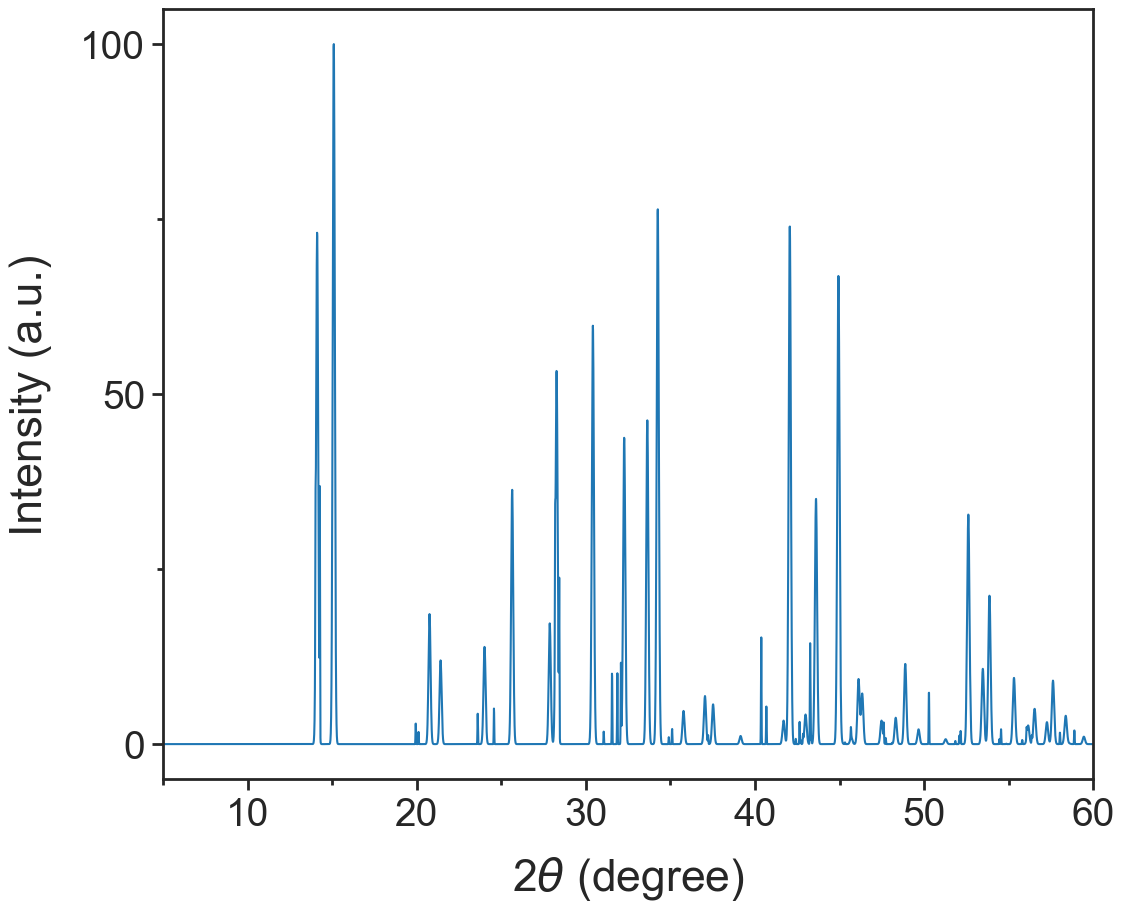

(5501,)


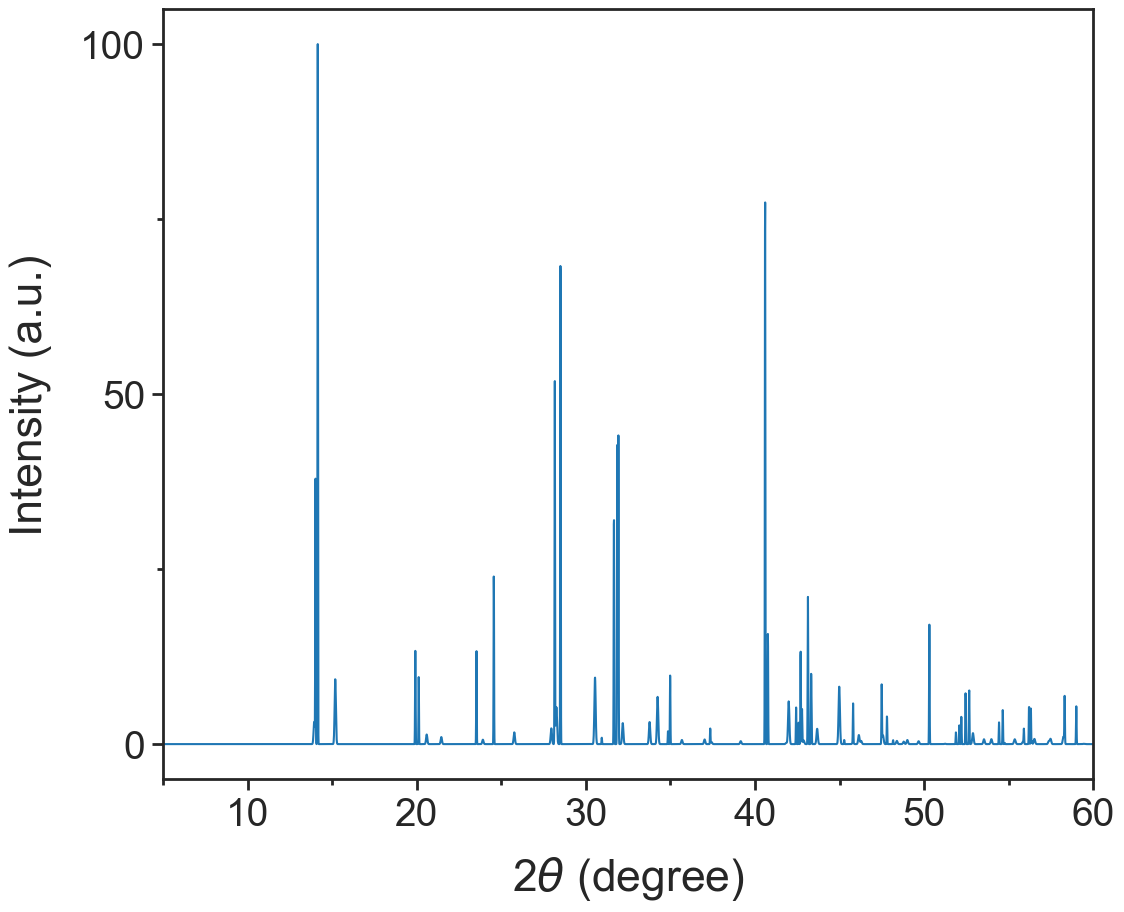

(5501,)


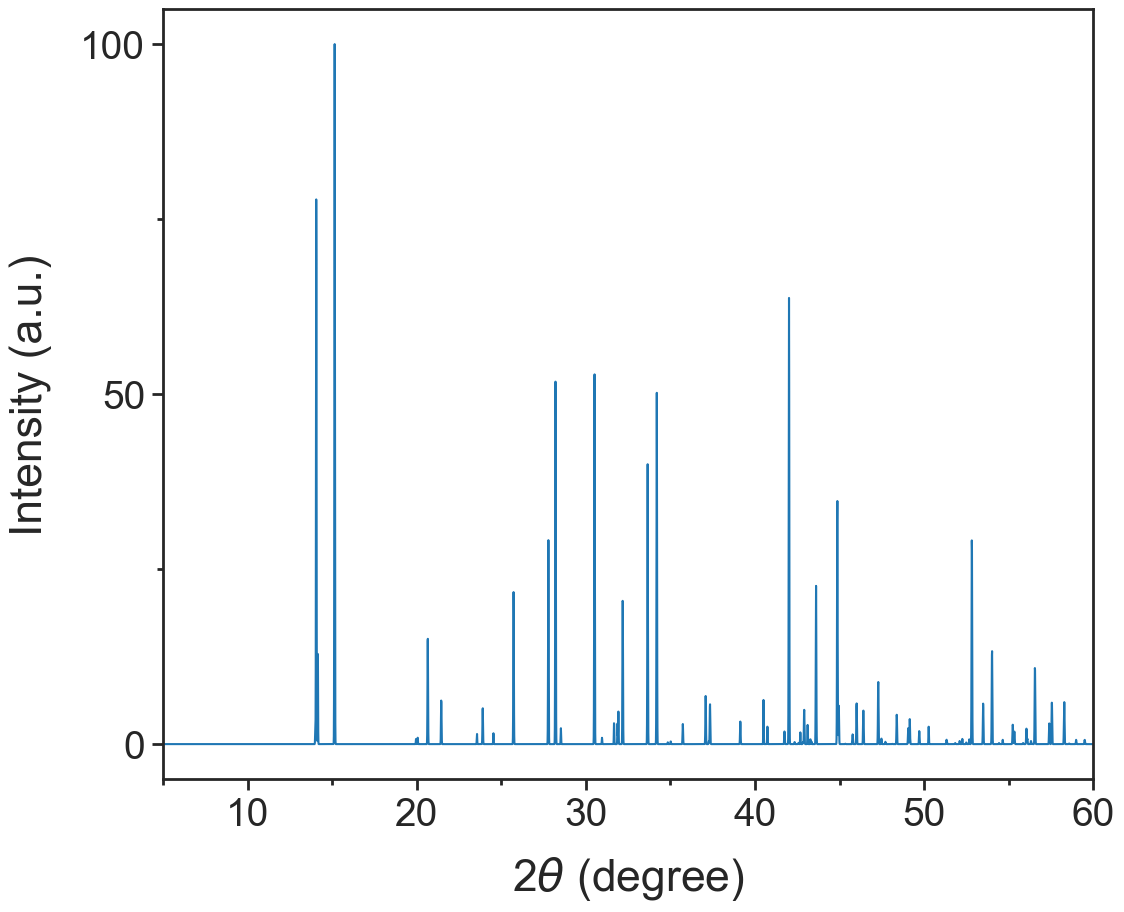

(5501,)


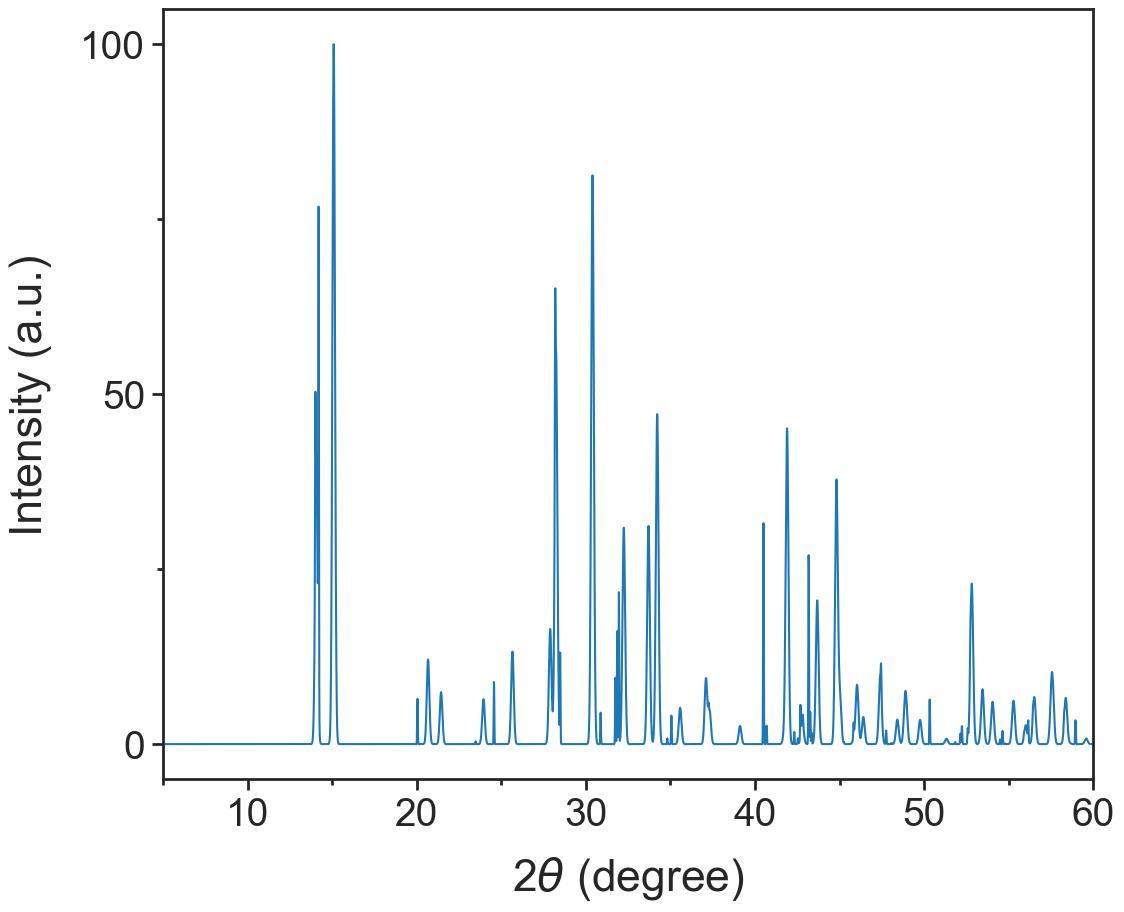

(5501,)


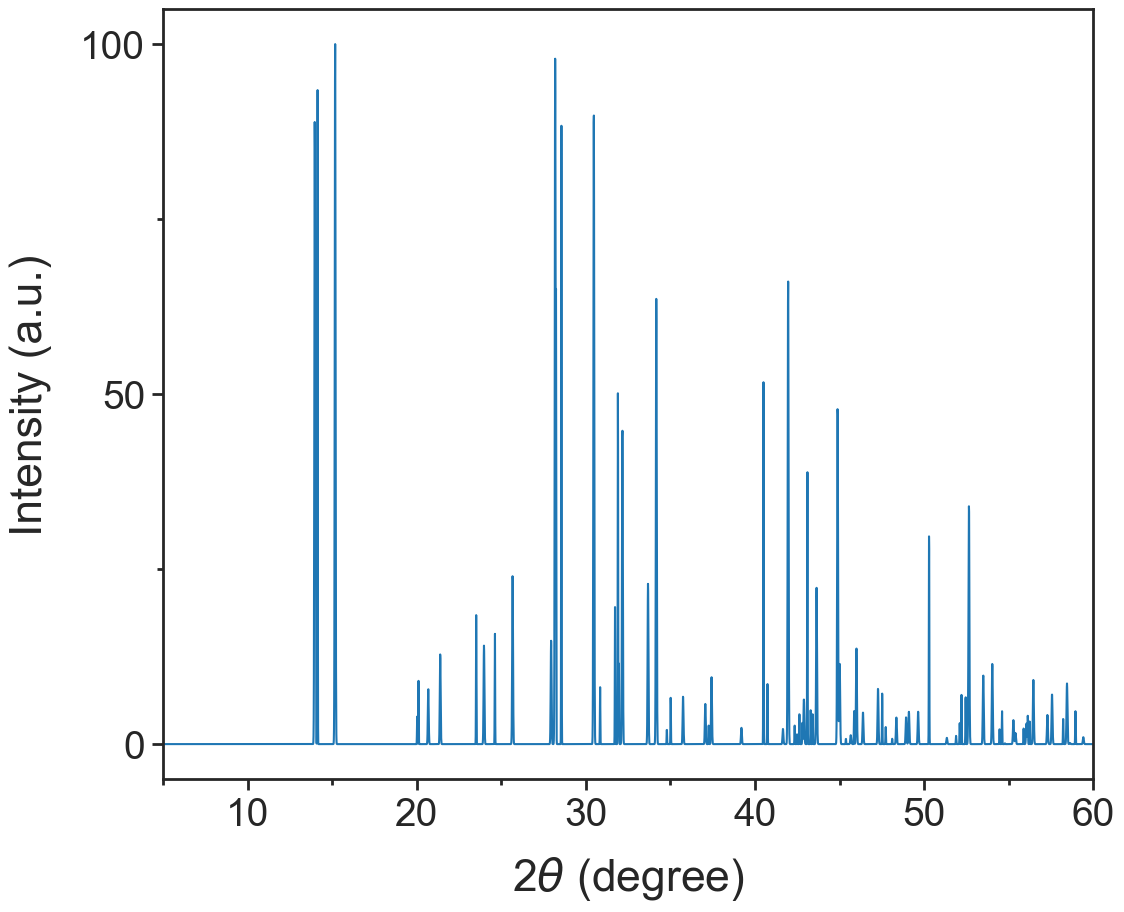

(5501,)


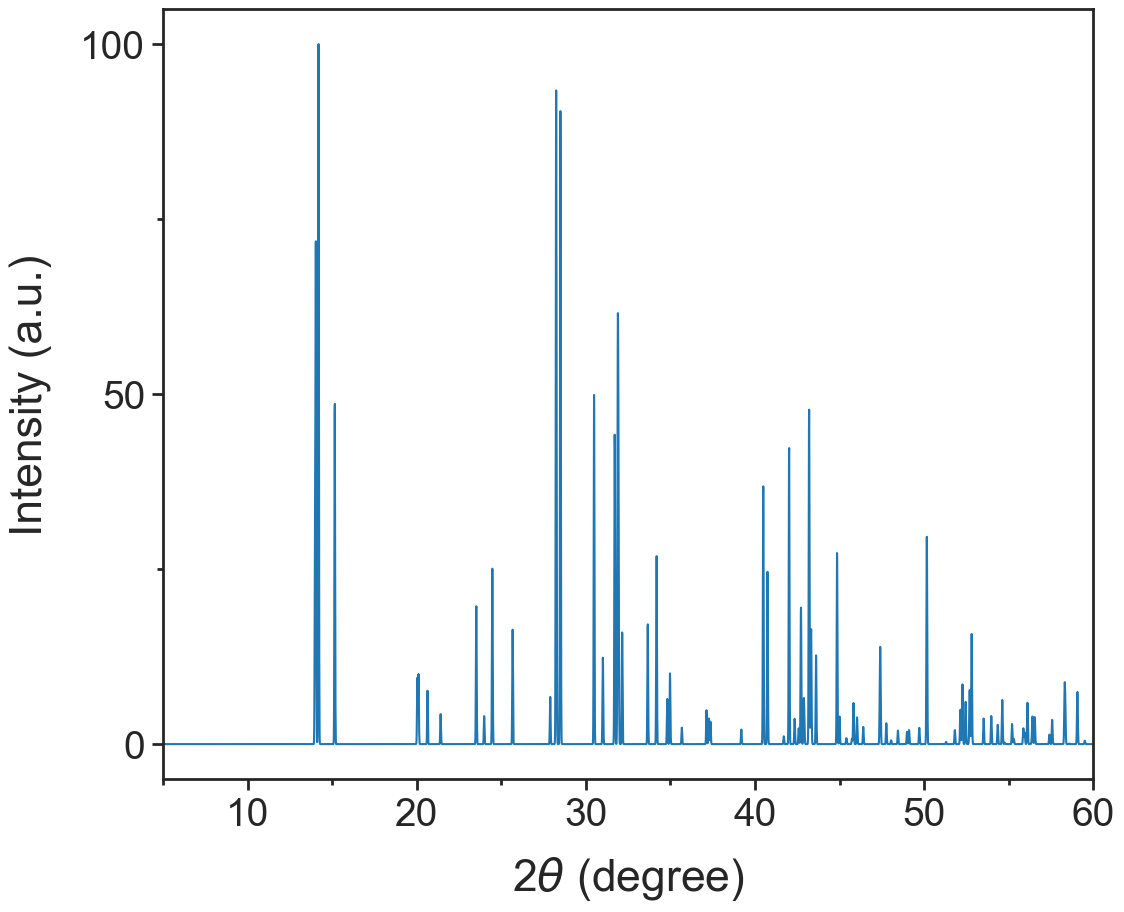

(5501,)


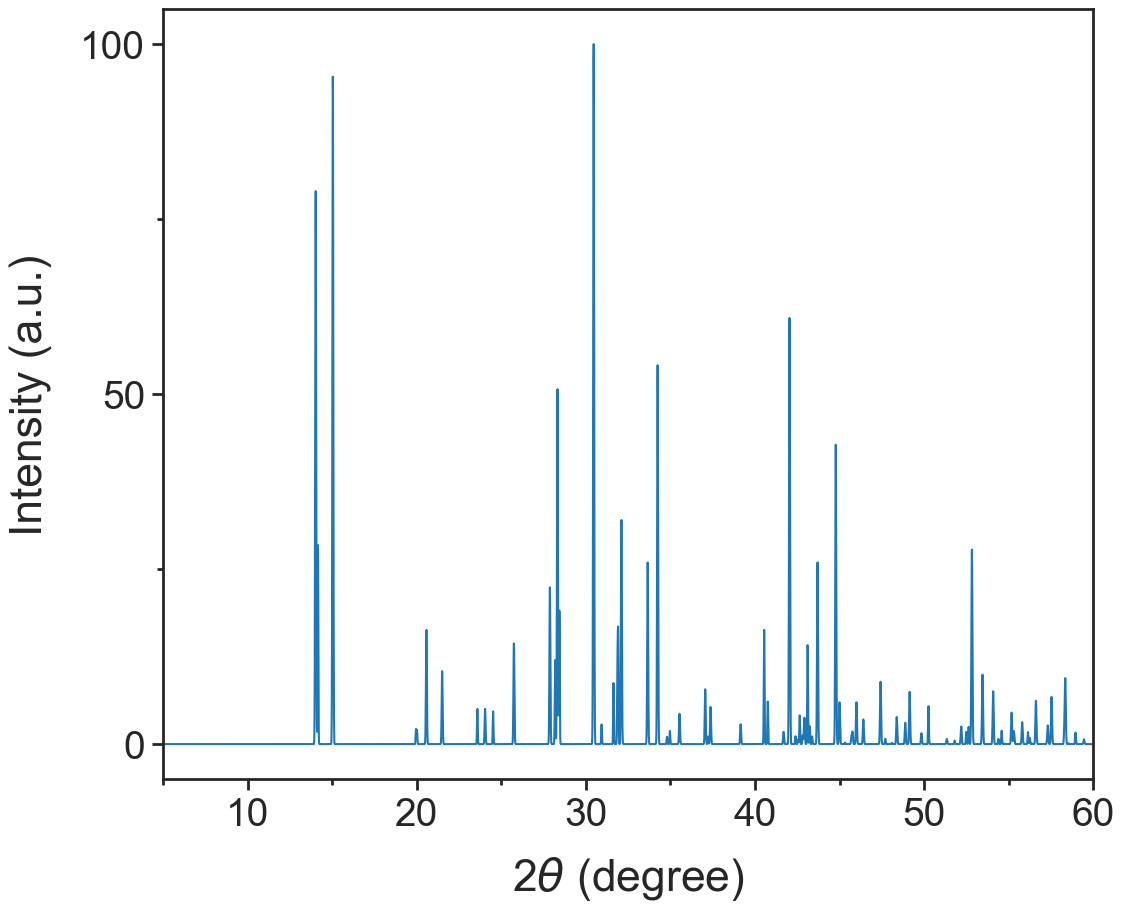

In [345]:
# Parameters for generation
crystal_size_range = (5, 50)  # A
position_shift_std_range = (0.01, 0.1)  # degrees 2θ
intensity_variation_std_range = (0.1, 0.5)  # percentage
peak_loss_probability_range = (0.2, 0.5)  # probability of peak loss
num_two_mixed_patterns = 10  # number of noisy patterns to generate per CIF file

# two phases mixed XRD pattern generation
xrd_patterns_list = []
texts_list = []
labels_list = []
idx1 = 0
idx2 = 1

two_mixed_dataset_path = os.path.join(folder, 'two_mixed_dataset_{}_{}.npy'.format(idx1,idx2))

for j in range(0,num_two_mixed_patterns):
    two_mixed_xrd, texts, labels = generate_two_mixed_xrd(idx1,idx2)
    print(two_mixed_xrd.shape)
    # Plot the XRD pattern
    load_plt_setting()
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.plot(two_theta_range, two_mixed_xrd)
    ax.set_xlabel(r'2$\theta$ (degree)',labelpad=15,size=32)
    ax.set_ylabel('Intensity (a.u.)',labelpad=20,size=32)
    # ax.set_title('CsBiI-CsBiBr')
    # ax.set_ylim(-5,105)
    ax.set_xlim(5, 60)
    ax.tick_params(axis='both', direction='out', length=8, width=2, pad=5, labelsize=28)
    ax.tick_params(axis='both', which='minor', direction='out', length=4, width=2, pad=5)
    ax.minorticks_on()
    ax.yaxis.set_ticks([])
    # plt.legend(fontsize=16)
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=False, steps=[1, 2, 5, 10]))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    # plt.savefig(f'/Users/shengfang/Dropbox (MIT)/high entropy/XRD/20240821/figure.svg', bbox_inches='tight',format='svg', dpi=300)
    # plt.savefig(f'/Users/shengfang/Dropbox (MIT)/high entropy/XRD/20240821/figure.png', bbox_inches='tight',format='png', dpi=300)
    plt.show()
    two_mixed_xrd_str = ";".join(map(str, two_mixed_xrd))
    xrd_patterns_list.append(two_mixed_xrd_str)
    texts_list.append(texts)
    labels_list.append(labels)

df = pd.DataFrame({
    "xrd_patterns": xrd_patterns_list,
    "texts": texts_list,
    "labels": labels_list
})

df.to_excel(output_excel_path, index=False)

(5501,)


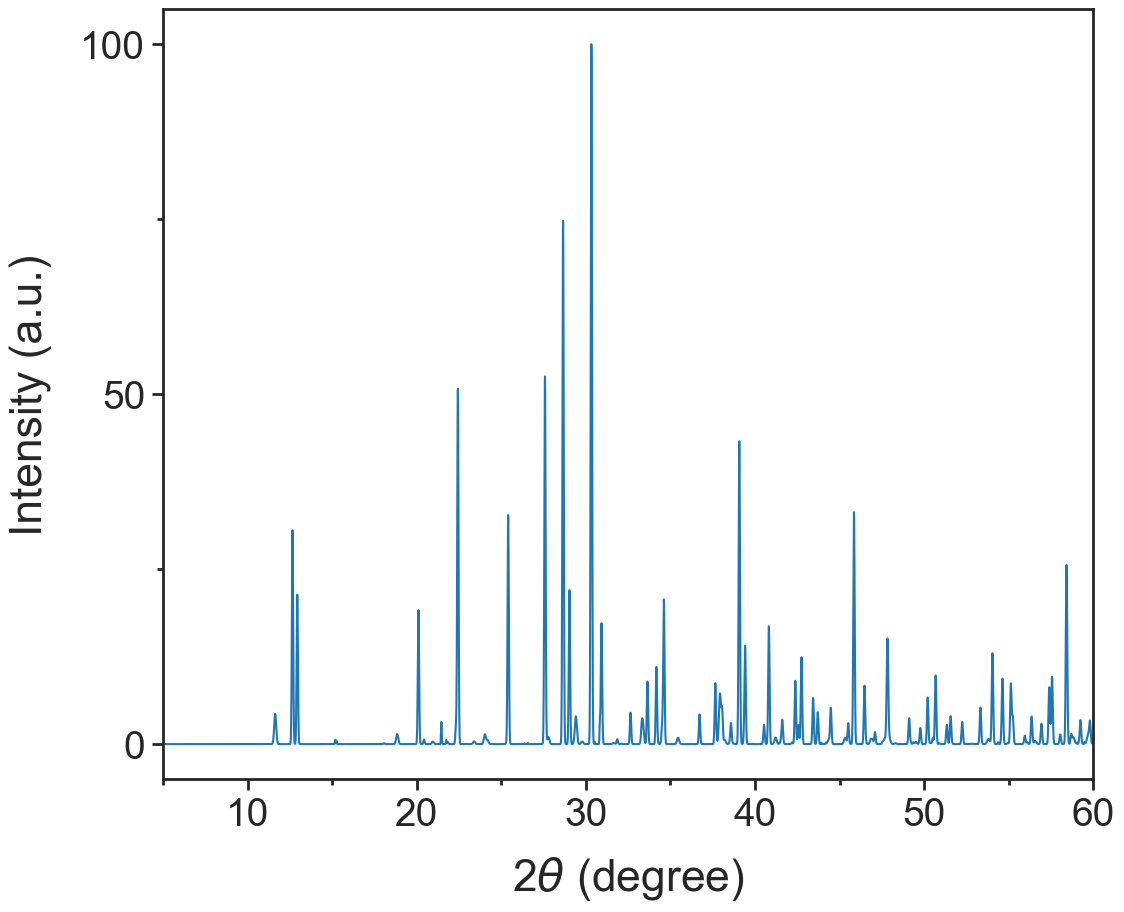

(5501,)


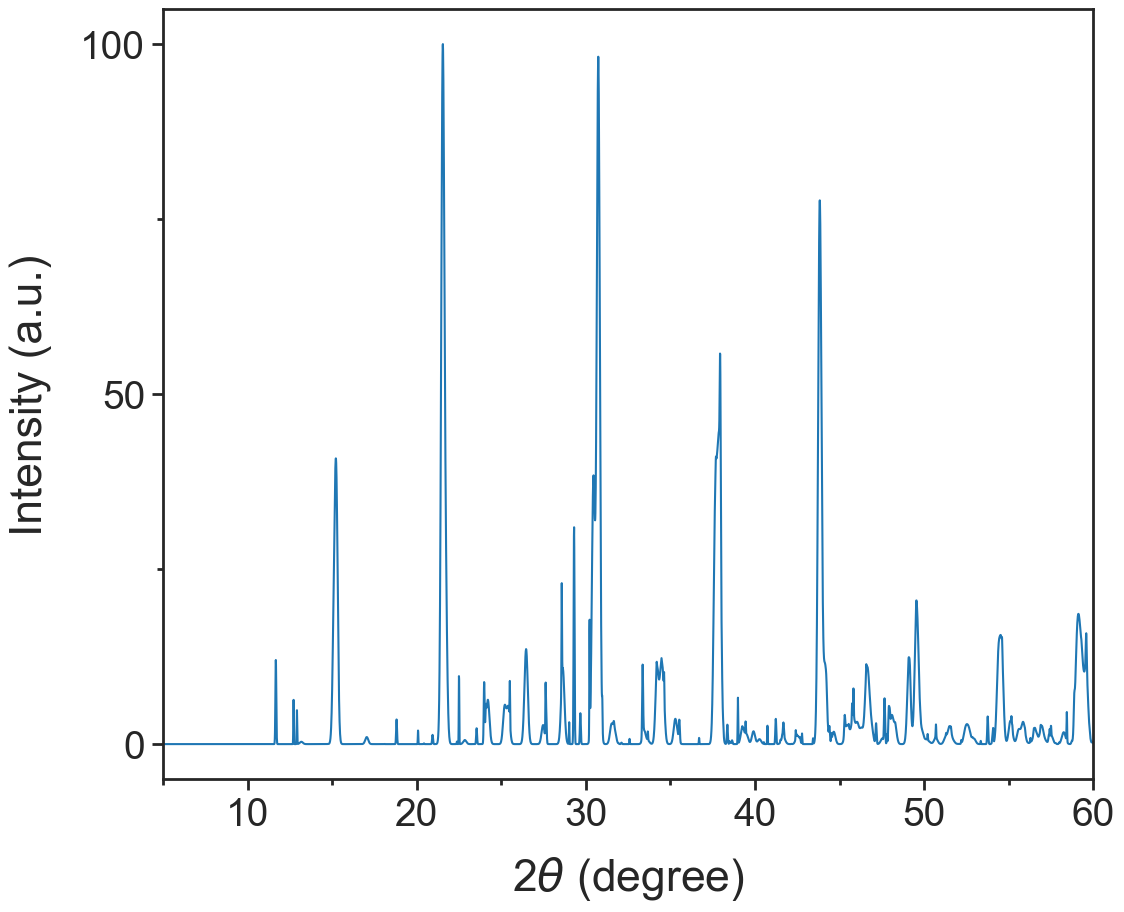

(5501,)


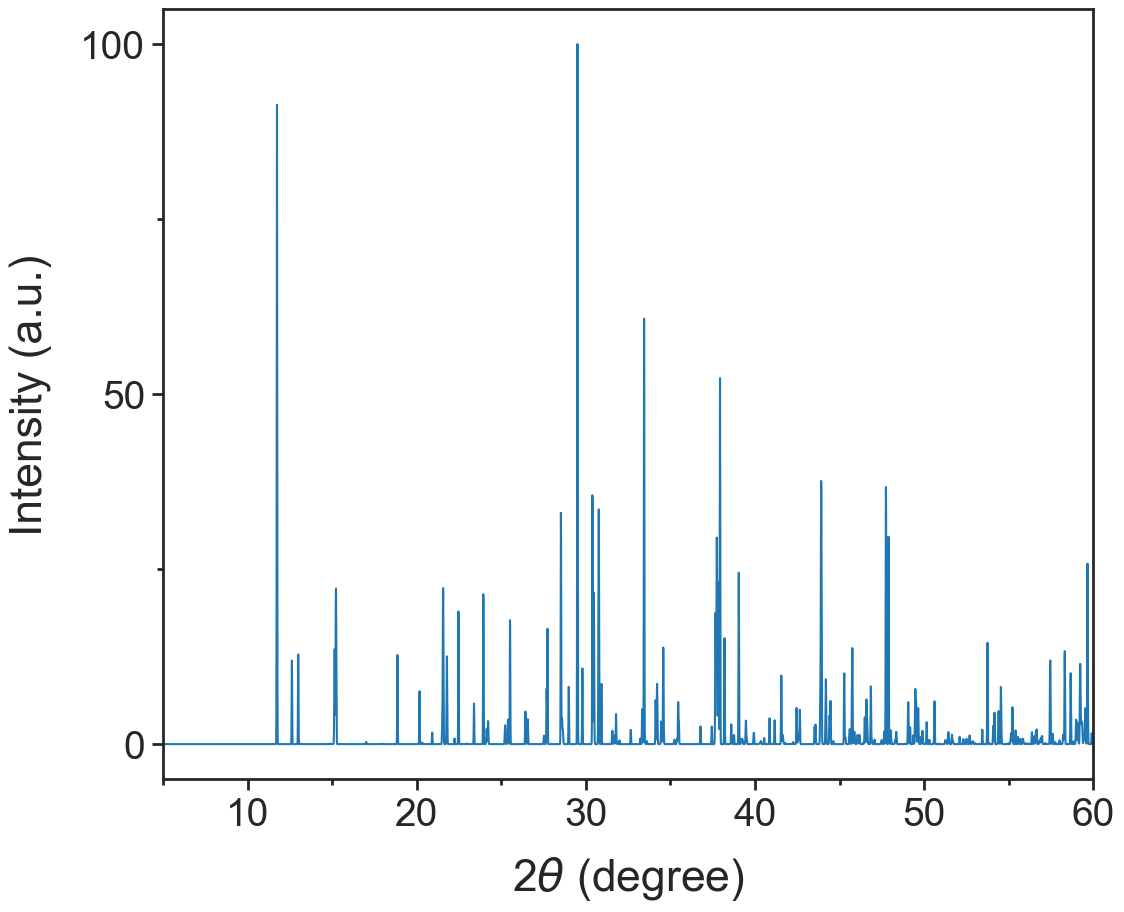

(5501,)


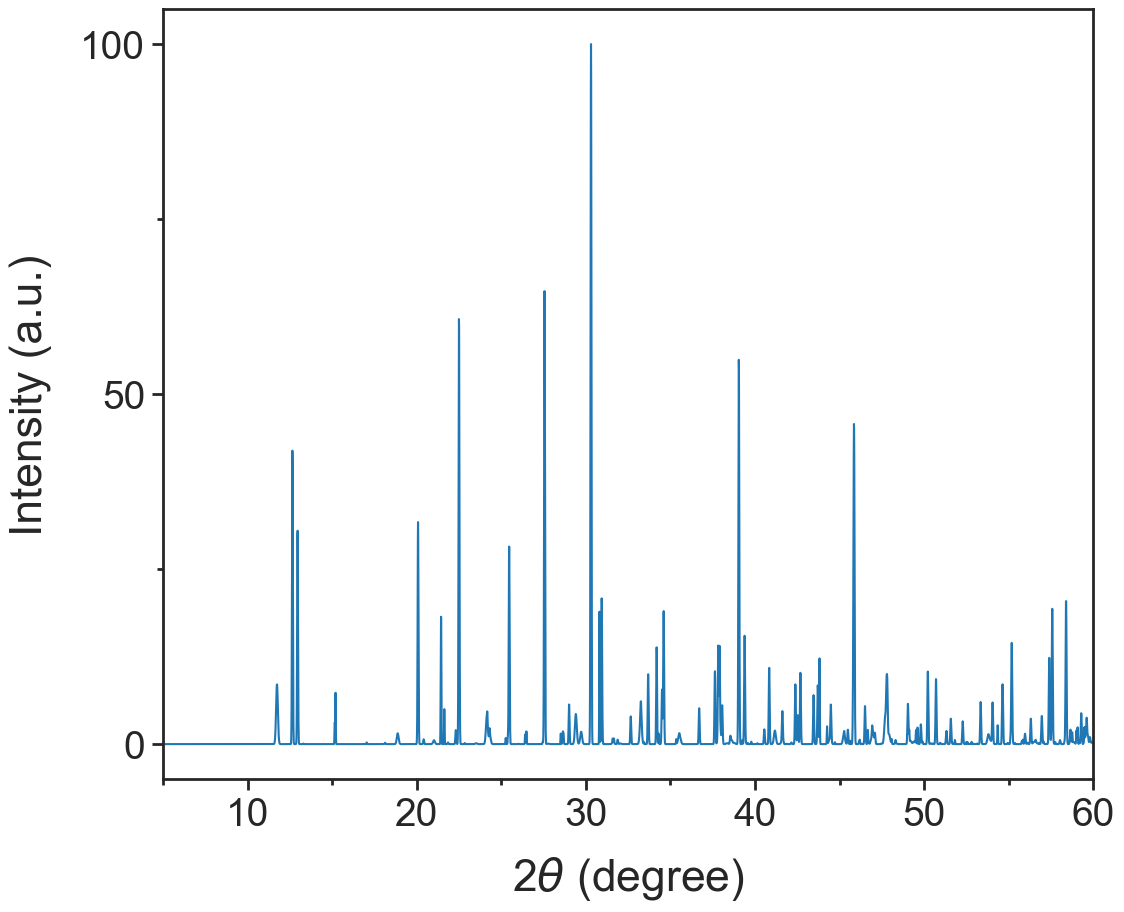

(5501,)


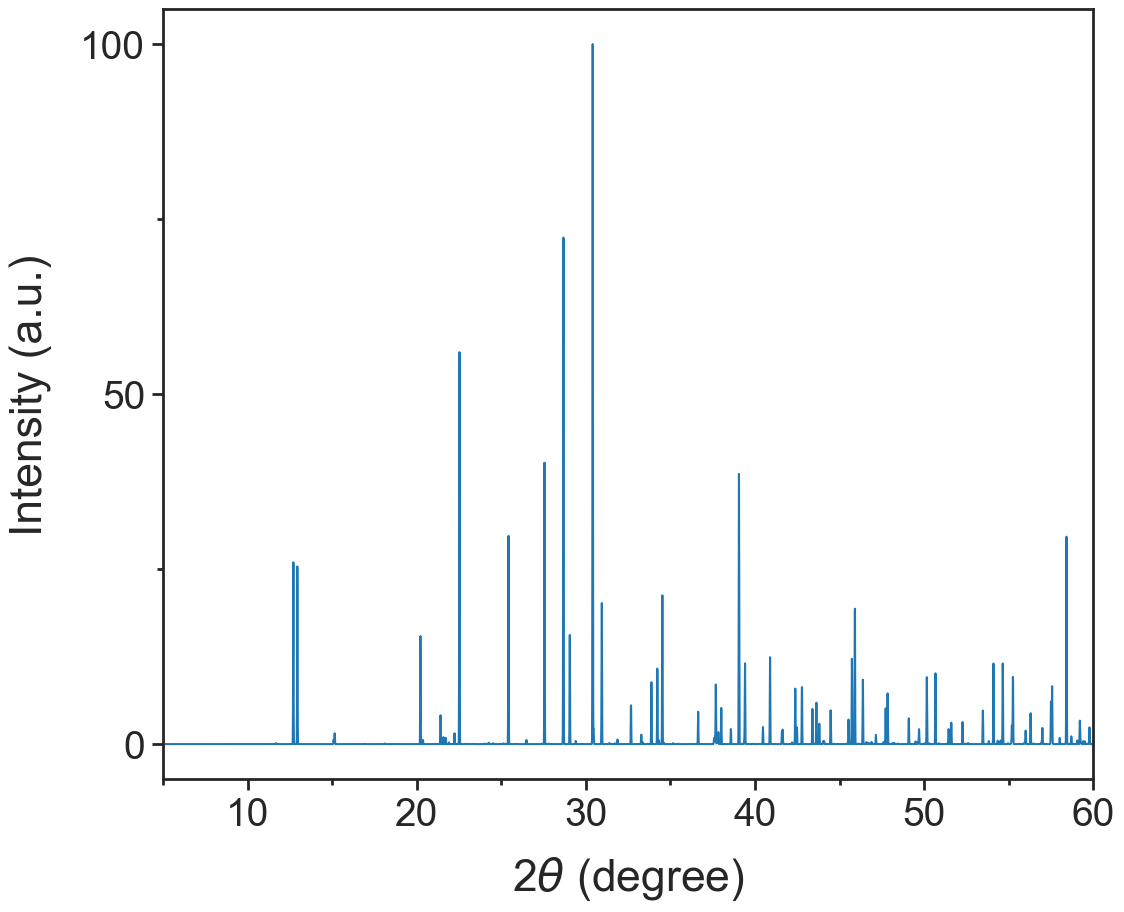

(5501,)


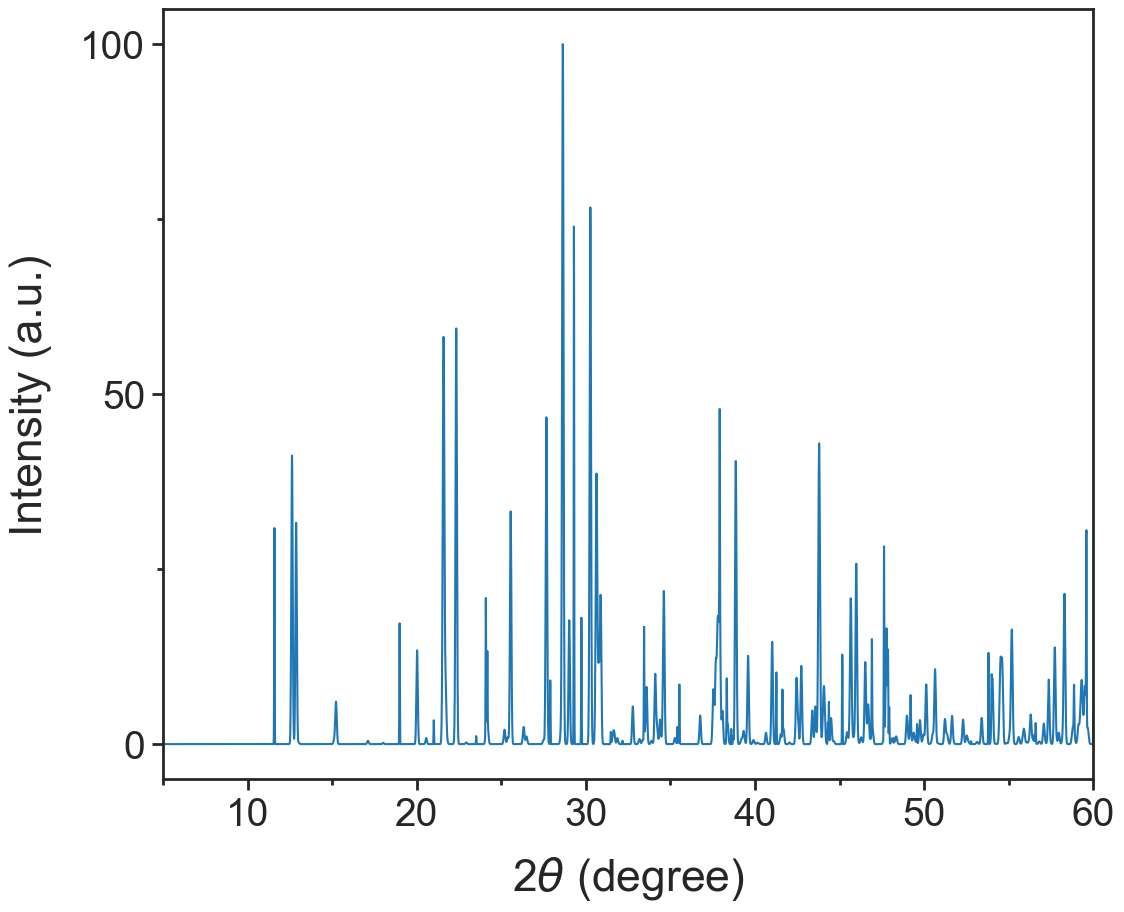

(5501,)


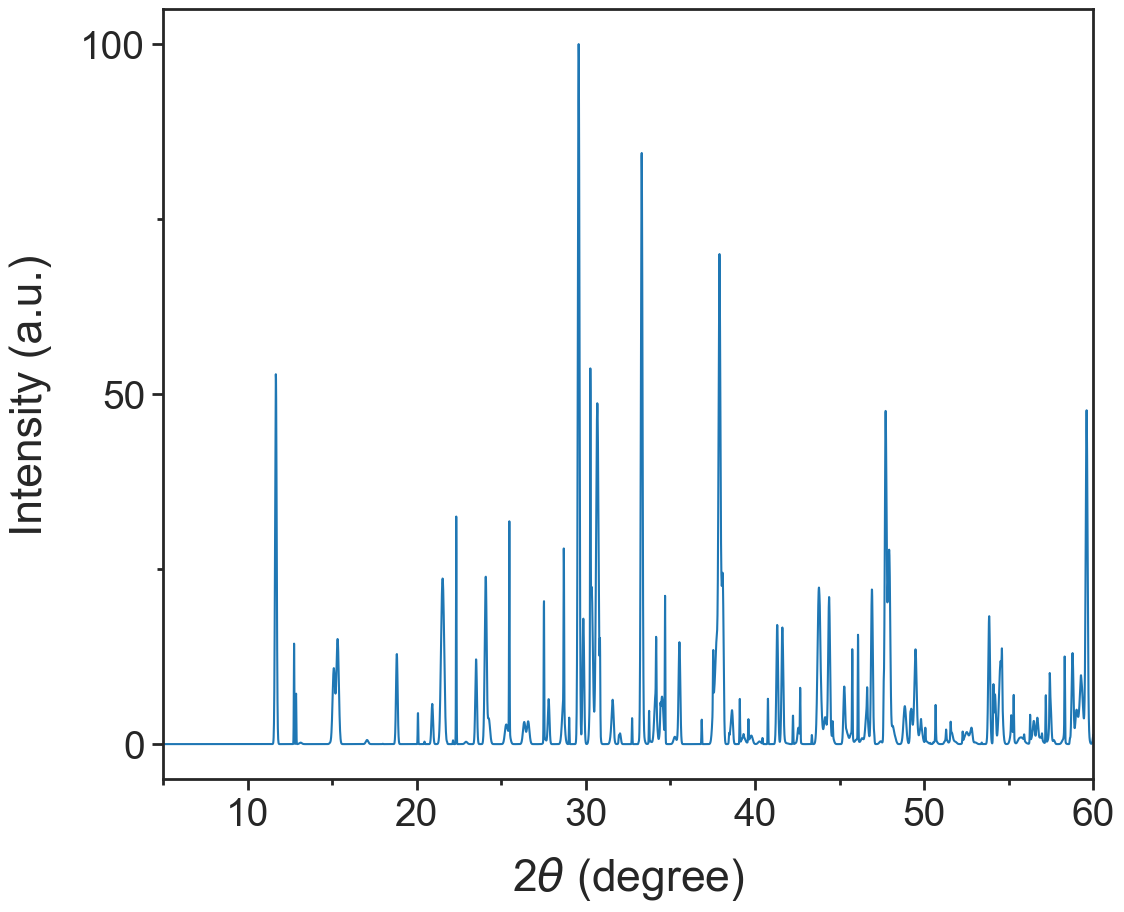

(5501,)


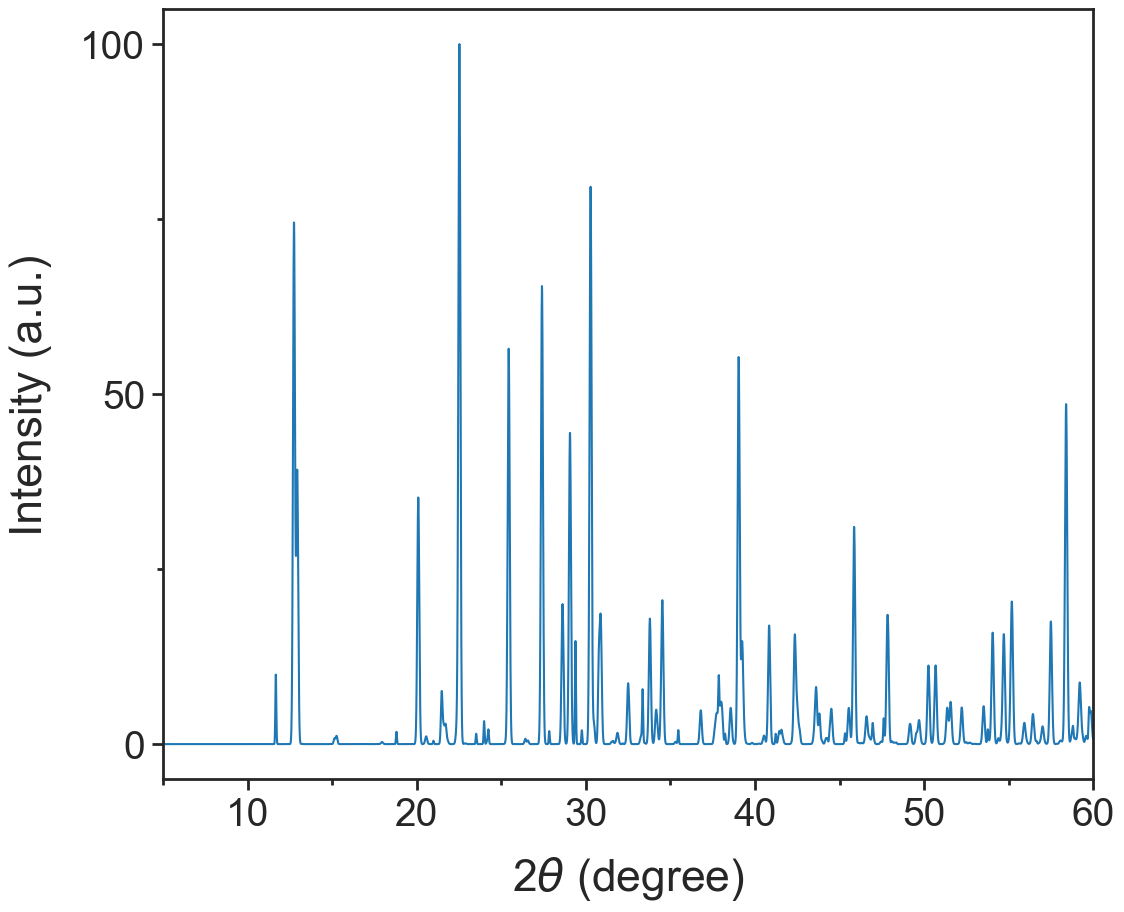

(5501,)


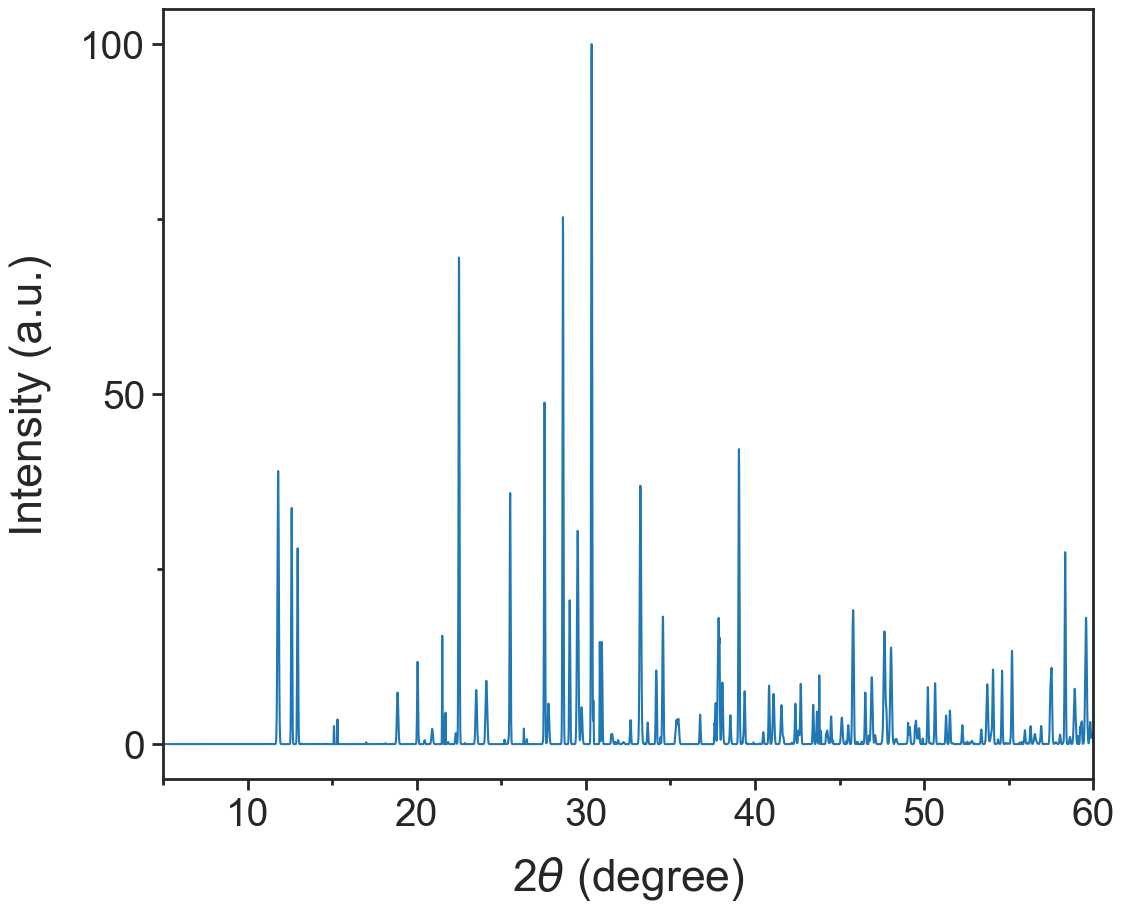

(5501,)


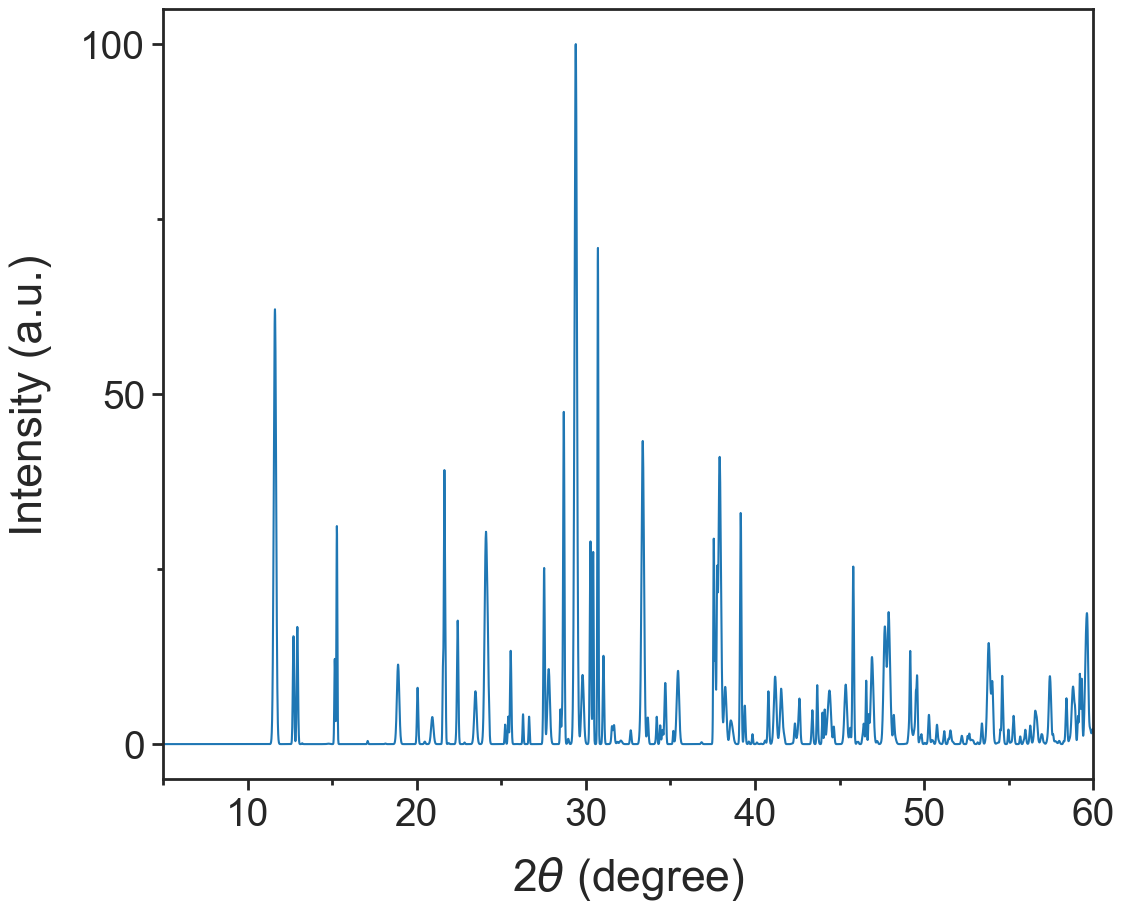

In [346]:
def generate_three_mixed_xrd(idx1,idx2,idx3):   ###idx comes from xrd_dataset.xlsx
    new_texts = []
    new_labels = []
    phase1, text1, label1 = get_simulated_pattern(idx1)
    noisy_phase1 = generate_noisy_xrd(phase1, crystal_size_range, position_shift_std_range, intensity_variation_std_range, peak_loss_probability_range)
    new_texts.append(text1)
    new_labels.append(label1)
    phase2, text2, label2 = get_simulated_pattern(idx2)
    noisy_phase2 = generate_noisy_xrd(phase2, crystal_size_range, position_shift_std_range, intensity_variation_std_range, peak_loss_probability_range)
    new_texts.append(text2)
    new_labels.append(label2)
    phase3, text3, label3 = get_simulated_pattern(idx3)
    noisy_phase3 = generate_noisy_xrd(phase3, crystal_size_range, position_shift_std_range, intensity_variation_std_range, peak_loss_probability_range)
    new_texts.append(text3)
    new_labels.append(label3)
    ratio1 = np.random.uniform(0,1)
    ratio2 = np.random.uniform(0,1. - ratio1)
    ratio3 = 1.- ratio1 - ratio2
    three_mixed_xrd = ratio1 * noisy_phase1 + ratio2 * noisy_phase2 + ratio3 * noisy_phase3
    three_mixed_xrd = three_mixed_xrd / np.max(three_mixed_xrd) * 100.  # Normalize to 100
    return three_mixed_xrd, new_texts, new_labels

# Parameters for generation
crystal_size_range = (5, 50)  # A
position_shift_std_range = (0.01, 0.1)  # degrees 2θ
intensity_variation_std_range = (0.1, 0.5)  # percentage
peak_loss_probability_range = (0.2, 0.5)  # probability of peak loss
num_three_mixed_patterns = 10  # number of noisy patterns to generate per CIF file

# two phases mixed XRD pattern generation
xrd_patterns_list = []
texts_list = []
labels_list = []
idx1 = 10
idx2 = 11
idx3 = 21
for j in range(0,num_three_mixed_patterns):
    three_mixed_xrd, texts, labels = generate_three_mixed_xrd(idx1,idx2,idx3)
    print(three_mixed_xrd.shape)
    # Plot the XRD pattern
    load_plt_setting()
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.plot(two_theta_range, three_mixed_xrd)
    ax.set_xlabel(r'2$\theta$ (degree)',labelpad=15,size=32)
    ax.set_ylabel('Intensity (a.u.)',labelpad=20,size=32)
    # ax.set_title('CsBiI-CsBiBr')
    # ax.set_ylim(-5,105)
    ax.set_xlim(5, 60)
    ax.tick_params(axis='both', direction='out', length=8, width=2, pad=5, labelsize=28)
    ax.tick_params(axis='both', which='minor', direction='out', length=4, width=2, pad=5)
    ax.minorticks_on()
    ax.yaxis.set_ticks([])
    # plt.legend(fontsize=16)
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=False, steps=[1, 2, 5, 10]))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    # plt.savefig(f'/Users/shengfang/Dropbox (MIT)/high entropy/XRD/20240821/figure.svg', bbox_inches='tight',format='svg', dpi=300)
    # plt.savefig(f'/Users/shengfang/Dropbox (MIT)/high entropy/XRD/20240821/figure.png', bbox_inches='tight',format='png', dpi=300)
    plt.show()
    three_mixed_xrd_str = ";".join(map(str, three_mixed_xrd))
    xrd_patterns_list.append(three_mixed_xrd_str)
    texts_list.append(texts)
    labels_list.append(labels)

df = pd.DataFrame({
    "xrd_patterns": xrd_patterns_list,
    "texts": texts_list,
    "labels": labels_list
})
output_excel_path = f'/Users/shengfang/Dropbox (MIT)/XRD phase identification/three_mixed_dataset_{idx1}_{idx2}_{idx3}.xlsx'
df.to_excel(output_excel_path, index=False)